In [100]:
import pandas_datareader.data as web
import datetime
#from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import requests
import pandas as pd 
import io
import numpy as np
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

In [101]:
figsize = (12,5)
fontsize = 10

## Import google trends data and Michigan data 

In [102]:
## google search 
ue_search = pd.read_excel('../Data/UEGoogle.xls')
ue_search.index = ue_search['Month']

ue_search.index = pd.DatetimeIndex(pd.to_datetime(ue_search.index,
                                                  format = '%Y-%m'),
                                  freq='infer')
ue_search.index.name = None

ue_search = ue_search.rename(columns = 
                             {'unemployment insurance: (United States)':'Search: \"unemployment insurance\"',
                             'unemployment office: (United States)':'Search: \"unemployment office\"',
                             'file for unemployment: (United States)':'Search: \"file for unemployment\"',
                             'unemployment: (United States)':'Search: \"unemployment\"'}
                            )

In [103]:
searches = ['Search: \"unemployment insurance\"',
            'Search: \"unemployment\"',
            'Search: \"unemployment office\"',
            'Search: \"file for unemployment\"']

##########################################################
sub_searches = searches[0:2]
#########################################################

ue_search = ue_search[sub_searches]

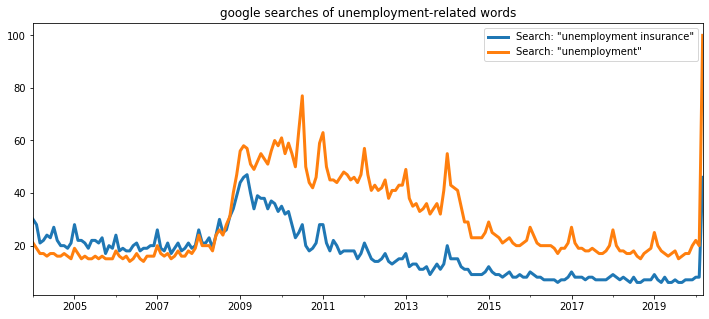

In [104]:
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words')
plt.savefig('figures/search')

In [105]:
## normalize each indicies by its initial value. 

for search in sub_searches:
    ue_search[search] = ue_search[search]*100/ue_search[search][0]

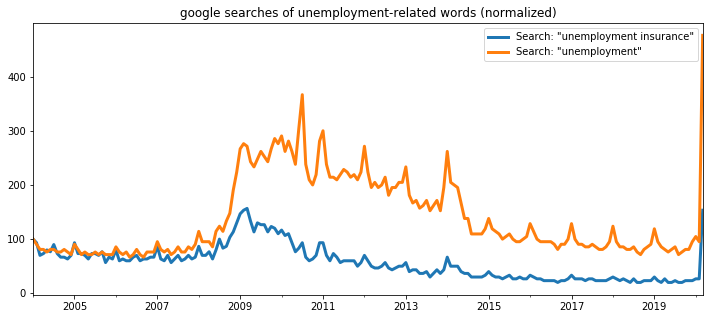

In [106]:
## after normalization
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words (normalized)')
plt.savefig('figures/search_normalized')

In [107]:
## michigan data 
ue_exp = pd.read_excel('../Data/UEExpMichigan.xls',
                       sheet_name = 'Data',
                       index_col = 0)

ue_exp = ue_exp.loc[ue_exp.index.dropna(how='all')]

ue_exp.index = pd.DatetimeIndex(pd.to_datetime(ue_exp.index,
                                               format = '%Y-%m-%d'),
                                  freq = 'infer')
ue_exp.index.name = None

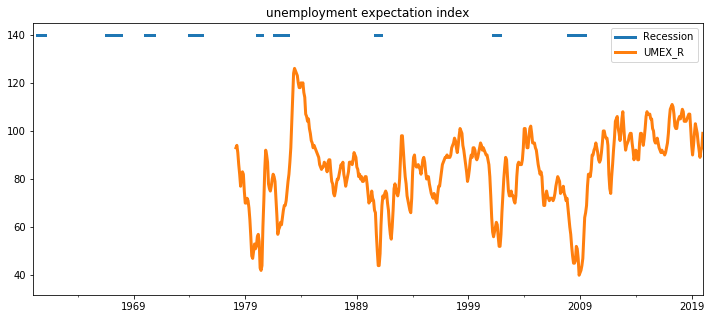

In [108]:
ue_exp.plot(lw = 3,
            figsize = figsize,
           title = 'unemployment expectation index')
plt.savefig('figures/ue_exp_idx')

In [109]:
ue_exp.tail()

,Recession,UMEX_R
2019-09-01,NaN,92.0
2019-10-01,NaN,89.0
2019-11-01,NaN,92.0
2019-12-01,NaN,93.0
2020-01-01,NaN,99.0


## Unemployement rate

In [110]:
start = datetime.datetime(1960, 1, 30)
end = datetime.datetime(2020, 3, 30)
ue = web.DataReader('UNRATE', 'fred', start, end)

In [111]:
ue.index = pd.DatetimeIndex(pd.to_datetime(ue.index,
                                           format = '%Y-%m-%d'),
                                  freq = 'infer')
ue.index.name = None

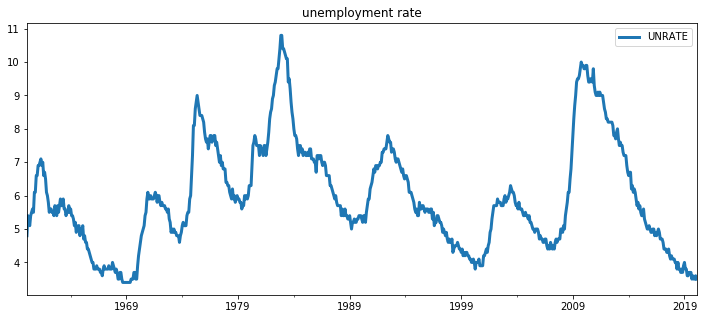

In [112]:
ue.plot(lw = 3,
        figsize = figsize,
        title = 'unemployment rate')
plt.savefig('figures/ue')

## Retail series (excluding vehicles and gas) 

In [113]:
## downloading data from fred 

retail = web.DataReader('MARTSSM44W72USS', 'fred', start, end)
pce_idx = web.DataReader('PCEPI', 'fred', start, end)

retail.index = pd.DatetimeIndex(pd.to_datetime(retail.index,
                                               format = '%Y-%m-%d'),
                                freq = 'MS')

retail = retail.rename(columns={'MARTSSM44W72USS':'retail'})

pce_idx.index = pd.DatetimeIndex(pd.to_datetime(pce_idx.index,
                                               format = '%Y-%m-%d'),
                                freq = 'infer')
retail.index.name = None
pce_idx.index.name = None

## converting from nominal to real  

retail_pce = pd.merge(retail,
                      pce_idx,
                      left_index = True,
                      right_index = True)

In [114]:
retail_pce['deflator'] = retail_pce['PCEPI']/retail_pce['PCEPI'][0]
retail_pce['retail_real'] = retail_pce['retail']/retail_pce['deflator']
retail_pce['lretail_real'] = np.log(retail_pce['retail_real'])
retail_pce['retail_yoy'] = retail_pce['lretail_real'].diff(periods = 12)*100
retail = retail_pce['retail_yoy']

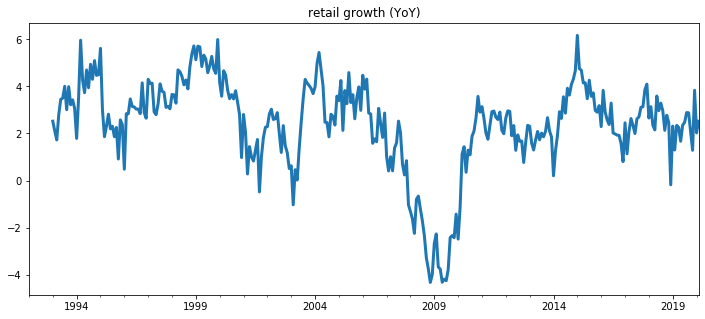

In [115]:
retail.plot(lw = 3,
        figsize = figsize,
        title = 'retail growth (YoY)')
plt.savefig('figures/retail')

## Combine all series 

In [116]:
temp = pd.merge(ue_search,
                ue_exp,
                left_index = True,
                right_index = True,
                how = 'outer'
               )

uedf = pd.merge(temp,
               ue,
               left_index = True,
               right_index = True,
                how = 'outer')

df = pd.merge(uedf,
              retail,
              left_index = True,
              right_index = True,
              how = 'outer')

In [117]:
df = df.rename(columns = {'UNRATE':'ue',
                          'UMEX_R':'ue_exp_idx'})

In [118]:
df.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment"',
       'Recession', 'ue_exp_idx', 'ue', 'retail_yoy'],
      dtype='object')

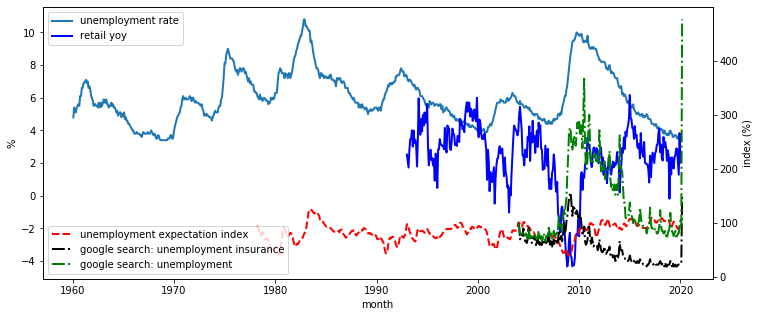

In [119]:
## plot all series 

fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(df.index,
        df['ue'],
        lw =2, 
        label = 'unemployment rate')

ax.plot(df.index,
        df['retail_yoy'],
        'b-',
        lw =2, 
        label = 'retail yoy')

ax2.plot(df.index,
         df['ue_exp_idx'],'r--',
         lw = 2, 
         label = 'unemployment expectation index')
ax2.plot(df.index,
         df['Search: \"unemployment insurance\"'],
         'k-.',
         lw = 2, 
         label = 'google search: unemployment insurance')
ax2.plot(df.index,
         df['Search: \"unemployment\"'],
         'g-.',
         lw = 2, 
         label = 'google search: unemployment')

#ax2.plot(df.index,df['Search: \"file for unemployment\"'],'g-.',lw = 1, label = 'google search: file for unemployment')
ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index (%)',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 3,
          fontsize = fontsize)
plt.savefig('figures/all')

## Regression

### Step 1.  predict michigan index using google search  


\begin{eqnarray}
\underbrace{\texttt{UEI}_{t}}_{\text{Unemployment expectation index}} = \alpha + \sum^2_{k=1}\beta_k \texttt{Search}_{k,t} + \epsilon_{t}
\end{eqnarray}

- $\texttt{UEI}$: unemployment expectation index
- $\texttt{Search}_{k,t}$: google search index for query $k$, e.g. "unemployment insurance", "unemployment office", etc. All indicies are normalized by their initial value at the first period of the sample. 

In [120]:
vars_reg = sub_searches + ['ue_exp_idx']

df_short1 = df[vars_reg].dropna(how ='any')

Y = df_short1[['ue_exp_idx']]
X = df_short1[sub_searches]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             ue_exp_idx   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           7.25e-33
Time:                        18:07:03   Log-Likelihood:                -738.92
No. Observations:                 193   AIC:                             1484.
Df Residuals:                     190   BIC:                             1494.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [121]:
coefs1 = results.params
r2_1 = round(results.rsquared,3)

print('Coefficients of interest:')
print(coefs1)

print('R-squared:')
print(r2_1)

Coefficients of interest:
const                               103.707630
Search: "unemployment insurance"     -0.458891
Search: "unemployment"                0.077344
dtype: float64
R-squared:
0.541


In [122]:
def predict_ue_exp(searches,
                   coefs):
    predict_values = coefs[0] + (coefs[1]*searches.T[0]  # important to transform the matrix
                                 + coefs[2]*searches.T[1]
                                 # + coefs1[3]*uedf[searches[2]]
                                )
    return predict_values

In [123]:
## predict the UEI using google trends in/out of sample 

ue_exp_idx_prd = predict_ue_exp(np.array(df[sub_searches].dropna(how ='any')),
                                coefs1)
ue_exp_idx_prd_index = df[sub_searches].dropna(how ='any').index  # two months in the end are out of sample.

prd_df = pd.DataFrame(ue_exp_idx_prd,
                      columns = ['ue_exp_idx_prd'],
                      index = ue_exp_idx_prd_index)
 
## add the predicted uei to the master dataframe 

df = pd.merge(df,
             prd_df,
             left_index = True,
             right_index = True,
             how = 'outer')

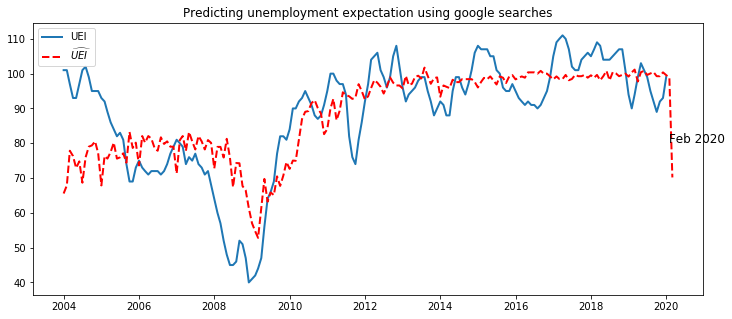

In [124]:
outsample_time =  datetime.datetime(2020,2,1)
fig = plt.figure(figsize = figsize)
plt.plot(df_short1.index,
         df_short1['ue_exp_idx'], lw = 2, label = 'UEI')
plt.plot(ue_exp_idx_prd_index,
         ue_exp_idx_prd,'r--',lw = 2,label=r'$\widehat{UEI}$')
plt.title('Predicting unemployment expectation using google searches')
plt.text(outsample_time, 80, 'Feb 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.savefig('figures/ue_exp_idx_predict')
# Make this an out of sample plot (for the predicted)

In [125]:
df.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment"',
       'Recession', 'ue_exp_idx', 'ue', 'retail_yoy', 'ue_exp_idx_prd'],
      dtype='object')

### Step 2.  predict future realized unemployment rate change using expectations 

\begin{eqnarray}
\texttt{U}_{t+h} - \texttt{U}_{t} & = & a_{0}+ a_{1}\widehat{\texttt{UEI}}_{t} + \eta_{t}
\end{eqnarray}

- $\texttt{U}_{t+h}$: h-month-ahead realized unemployment rate, h = 12 by default. change h to predict for different horizons 
- $\widehat{\texttt{UEI}}_{t}$: predicted unemployment rate expectation index at time $t$ 

\begin{eqnarray}
\widehat{\texttt{U}}_{t+h} &= & \hat{a}_{0}+ \hat{a}_{1}\widehat{\texttt{UEI}}_{t} + \texttt{U}_{t} 
\end{eqnarray}


### Model 1 for step 2. Use predicted UEI

In [126]:
## ols regression
df['ue_chg'] = df['ue'].diff(periods = 12) ## yoy change of unemployment rate 
df_short2 = df[['ue_chg','ue_exp_idx_prd']].dropna(how ='any')

## # of months lag 
############################################################
h = 12  #by default, next month unemployment rate 
#############################################################

Y = np.array(df_short2['ue_chg'][h:])
X = np.array(df_short2['ue_exp_idx_prd'][:-h])
X = sm.add_constant(X)
model2 = sm.OLS(Y,X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     62.84
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           2.27e-13
Time:                        18:07:04   Log-Likelihood:                -256.73
No. Observations:                 182   AIC:                             517.5
Df Residuals:                     180   BIC:                             523.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1180      0.541      7.617      0.0

In [127]:
coefs2 = results2.params
r2_2 = round(results2.rsquared,3)

print('When using predicted UEI')
print('Estimated coefficients:')
print(coefs2)

print('R-squared:')
print(r2_2)

When using predicted UEI
Estimated coefficients:
[ 4.11798949 -0.04843342]
R-squared:
0.259


In [128]:
# function that predict change in unemployment rate 

def predict_ue(uei,
               coefs):
    predict_values = coefs[0] + (coefs[1]*uei.T)
    return predict_values

In [129]:
## predict the UE changes using predicted UEI 

ue_chg_prd = predict_ue(np.array(df['ue_exp_idx_prd'].dropna(how ='any')),
                        coefs2)
ue_chg_index = df['ue_exp_idx_prd'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df2 = pd.DataFrame(ue_chg_prd,
                       columns = ['ue_chg_prd'],
                       index = ue_chg_index)
df = pd.merge(df,
              prd_df2,
              left_index = True,
              right_index = True,
              how = 'outer')

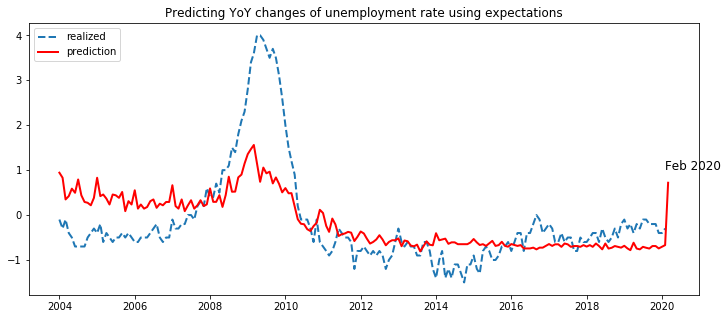

In [130]:
fig = plt.figure(figsize = figsize)

plt.plot(ue_chg_index,
         np.array(df['ue_chg'].loc[ue_chg_index]), 
         '--',
         lw = 2, 
         label = 'realized')
plt.plot(ue_chg_index,
         ue_chg_prd,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY changes of unemployment rate using predicted expectation index')
plt.text(outsample_time, 1, 'Feb 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.savefig('figures/ue_change_predict_predicted_uei')

### Model 2 for step 2. Use realized UEI

In [131]:
## ols regression

df['ue_chg'] = df['ue'].diff(periods = 12) ## yoy change of unemployment rate 
df_short3 = df[['ue_chg','ue_exp_idx']].dropna(how ='any')

## # of months lag 
############################################################
h = 12  #by default, next month unemployment rate 
#############################################################

Y = np.array(df_short3['ue_chg'][h:])
X = np.array(df_short3['ue_exp_idx'][:-h])
X = sm.add_constant(X)
model3 = sm.OLS(Y,X)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     163.8
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           5.54e-33
Time:                        18:07:08   Log-Likelihood:                -726.37
No. Observations:                 548   AIC:                             1457.
Df Residuals:                     546   BIC:                             1465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4038      0.196     12.276      0.0

In [132]:
coefs3 = results3.params
r2_3 = round(results3.rsquared,3)

print('When using realized  UEI')
print('Estimated coefficients:')
print(coefs3)

print('R-squared:')
print(r2_3)

When using realized  UEI
Estimated coefficients:
[ 2.40379316 -0.02910323]
R-squared:
0.231


In [133]:
## predict the UE changes using realized UEI 

ue_chg_prd2 = predict_ue(np.array(df['ue_exp_idx_prd'].dropna(how ='any')),
                        coefs3)

ue_chg_index2 = df['ue_exp_idx_prd'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df3 = pd.DataFrame(ue_chg_prd2,
                       columns = ['ue_chg_prd2'],
                       index = ue_chg_index2)
df = pd.merge(df,
              prd_df3,
              left_index = True,
              right_index = True,
              how = 'outer')

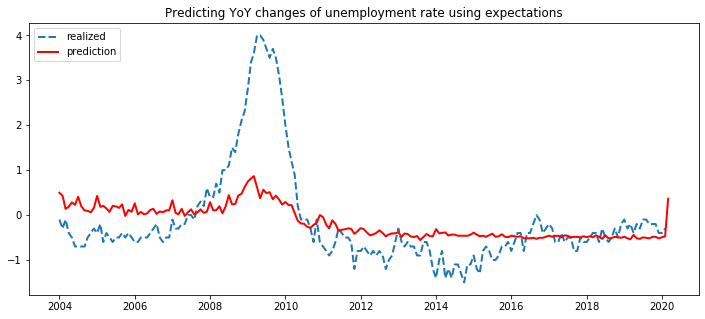

In [134]:
fig = plt.figure(figsize = figsize)
plt.plot(ue_chg_index2,
         np.array(df['ue_chg'].loc[ue_chg_index2]),
         '--',
         lw = 2, 
         label = 'realized')
plt.plot(ue_chg_index2,
         ue_chg_prd2,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY changes of unemployment rate using realized expectation index')
plt.text(outsample_time, 1, 'Feb 2020', fontsize = 12)  # mark the out-of-sample prediction 
plt.legend(loc = 2)
plt.savefig('figures/ue_change_predict_realized_uei')

## Zoom-in the recent sample 

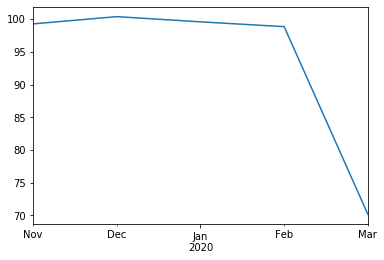

In [137]:
df['ue_exp_idx_prd'].tail().plot(title = 'predicted change in UEI')
plt.savefig('figures/ue_exp_idx_predict_recent')

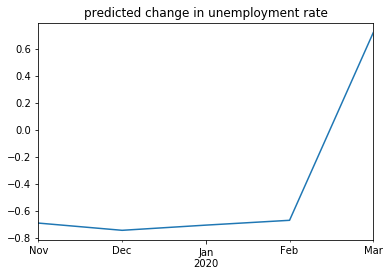

In [138]:
df['ue_chg_prd'].tail().plot(title = 'predicted YoY change in unemployment rate')
plt.savefig('figures/ue_change_predict_recent')

## Retail and unemployment expectations 


\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \hat{U}_{t+12} & \text{Over history to 2019-JAN}
\\ \Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \texttt{UEI}_{t} & \text{Over history to 2019-JAN}
\\ \Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} \widehat{\texttt{UEI}}_{t}  &\text{Using measured UEI data through its end, then forecasted UEI for last couple of months}
\end{eqnarray}